<a href="https://colab.research.google.com/github/KSithole9/ROAD-SIGN-CLASSIFICATION/blob/main/ROADSIGNCLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **#Import necessary libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import zipfile
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample
from keras.applications import ResNet50
from keras.applications import VGG16

# **#Loading and Preprocessing Data**

In [ ]:
# Extract ZIP file
zip_file = '/content/archive.zip'
extract_dir = 'extracted_folder'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load data from CSV files
train_data = pd.read_csv(os.path.join(extract_dir, 'Train.csv'))
test_data = pd.read_csv(os.path.join(extract_dir, 'Test.csv'))

# Convert "ClassId" column to string type
train_data['ClassId'] = train_data['ClassId'].astype(str)
test_data['ClassId'] = test_data['ClassId'].astype(str)


In [ ]:
# Define the class numbers you want to use (0 to 23)
selected_classes = [str(i) for i in range(24)]

# Filter the train and test data to include only the selected classes
filtered_train_data = train_data[train_data['ClassId'].isin(selected_classes)].copy()
filtered_test_data = test_data[test_data['ClassId'].isin(selected_classes)].copy()

# Map class IDs to a range from 0 to 23
class_mapping = {class_id: str(i) for i, class_id in enumerate(selected_classes)}

# Apply class mapping to the filtered data
filtered_train_data['ClassId'] = filtered_train_data['ClassId'].map(class_mapping)
filtered_test_data['ClassId'] = filtered_test_data['ClassId'].map(class_mapping)


In [ ]:
# Initialize an empty DataFrame for balanced training data
balanced_train_data = pd.DataFrame(columns=train_data.columns)

# Balance the training data
for class_id in train_data['ClassId'].unique():
    class_samples = train_data[train_data['ClassId'] == class_id]
    if len(class_samples) < 200:
        # Oversample the class to have 200 samples
        oversampled_class = resample(class_samples, replace=True, n_samples=200, random_state=42)
        balanced_train_data = pd.concat([balanced_train_data, oversampled_class], ignore_index=True)
    else:
        balanced_train_data = pd.concat([balanced_train_data, class_samples.sample(n=200, random_state=42)], ignore_index=True)

# Apply class mapping to the filtered data
filtered_train_data['ClassId'] = filtered_train_data['ClassId'].map(class_mapping)
filtered_test_data['ClassId'] = filtered_test_data['ClassId'].map(class_mapping)

# Data generators for the selected 24 classes
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_dataframe(
    dataframe=filtered_train_data,
    directory=extract_dir,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=filtered_test_data,
    directory=extract_dir,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Print the unique class IDs in the dataset
print("Unique Classes:", sorted(filtered_train_data['ClassId'].unique()))



Found 28200 validated image filenames belonging to 24 classes.
Found 9180 validated image filenames belonging to 24 classes.
Unique Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9']


# **Defining Class Names**

In [ ]:
# Define a dictionary mapping class IDs to their names
class_names = {
    '0': 'Speed limit (20km/h)',
    '1': 'Speed limit (30km/h)',
    '2': 'Speed limit (50km/h)',
    '3': 'Speed limit (60km/h)',
    '4': 'Speed limit (70km/h)',
    '5': 'Speed limit (80km/h)',
    '6': 'End of speed limit (80km/h)',
    '7': 'Speed limit (100km/h)',
    '8': 'Speed limit (120km/h)',
    '9': 'No passing',
    '10': 'No passing veh over 3.5 tons',
    '11': 'Right-of-way at intersection',
    '12': 'Priority road',
    '13': 'Yield',
    '14': 'Stop',
    '15': 'No vehicles',
    '16': 'Veh > 3.5 tons prohibited',
    '17': 'No entry',
    '18': 'General caution',
    '19': 'Dangerous curve left',
    '20': 'Dangerous curve right',
    '21': 'Double curve',
    '22': 'Bumpy road',
    '23': 'Slippery road'
}

# Replace the class IDs with their names in the DataFrame
filtered_train_data['ClassId'] = filtered_train_data['ClassId'].map(class_names)

# Print the unique class names in the dataset
print("Unique Class Names:", sorted(filtered_train_data['ClassId'].unique()))

Unique Class Names: ['Bumpy road', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'End of speed limit (80km/h)', 'General caution', 'No entry', 'No passing', 'No passing veh over 3.5 tons', 'No vehicles', 'Priority road', 'Right-of-way at intersection', 'Slippery road', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'Stop', 'Veh > 3.5 tons prohibited', 'Yield']


# **Plotting Distribution**

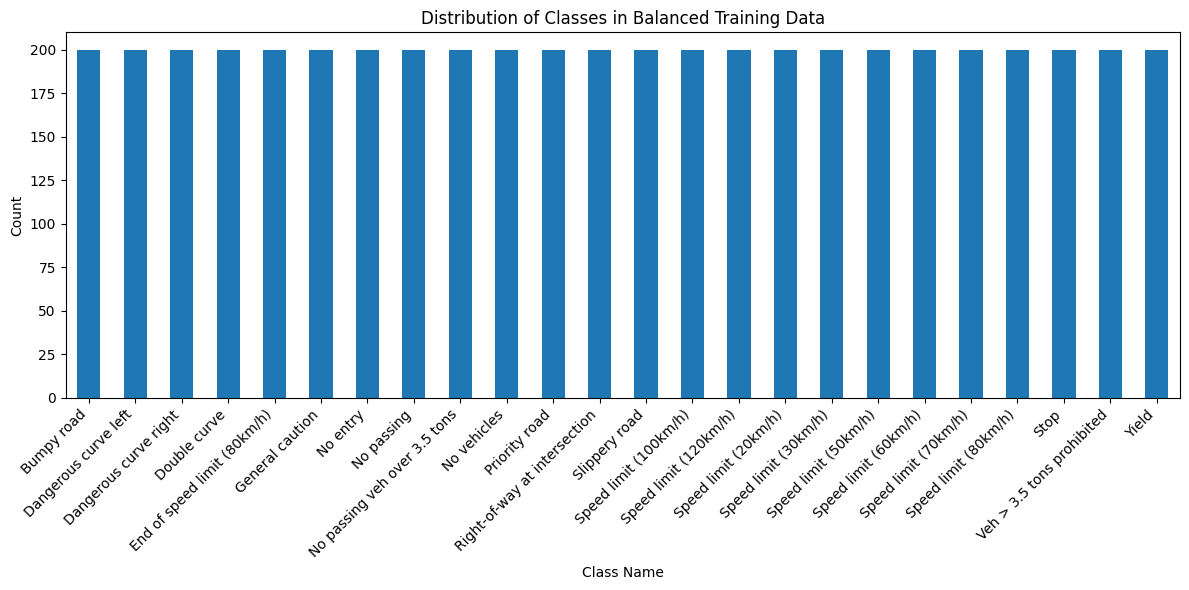

In [ ]:
# Plot the distribution of classes in the balanced training data with 24 classes and 200 samples per class
plt.figure(figsize=(12, 6))
balanced_train_data['ClassId'] = balanced_train_data['ClassId'].map(class_names)  # Map class IDs to names
balanced_train_data['ClassId'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Classes in Balanced Training Data')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# **Defining, Compiling and Training CNN Model:**

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(24, activation='softmax')  # Output layer with 24 units for 24 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the CNN model
history_cnn = cnn_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(filtered_train_data) // 32,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the CNN model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

#**Fine-tuning, Compiling and Training ResNet50 Model**



In [ ]:
# Load the ResNet50 model pre-trained on ImageNet data
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Fine-tune more layers of ResNet50
for layer in resnet_model.layers[:-10]:  # Fine-tune more layers
    layer.trainable = True

# Create custom top layers
top_model = Sequential()
top_model.add(Flatten(input_shape=resnet_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))  # Increased number of units
top_model.add(Dropout(0.5))  # Added dropout for regularization
top_model.add(Dense(24, activation='softmax'))

# Combine ResNet50 base and custom top layers
resnet_transfer_model = Sequential()
resnet_transfer_model.add(resnet_model)
resnet_transfer_model.add(top_model)

# Compile the model with a lower learning rate and a learning rate scheduler
resnet_transfer_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the ResNet50 model
history_resnet = resnet_transfer_model.fit(
    train_generator,
    epochs=10,  # Increase epochs for better convergence
    steps_per_epoch=len(filtered_train_data) // 32,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the ResNet50 model on the test data
test_loss_resnet, test_accuracy_resnet = resnet_transfer_model.evaluate(test_generator)

print("Test Loss (ResNet50):", test_loss_resnet)
print("Test Accuracy (ResNet50):", test_accuracy_resnet)

94765736/94765736 [==============================] - 1s 0us/step


Epoch 1/10
881/881 [==============================] - 2041s 2s/step - loss: 1.5079 - accuracy: 0.5613 - val_loss: 1.5613 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 2/10
881/881 [==============================] - 2034s 2s/step - loss: 0.8394 - accuracy: 0.7446 - val_loss: 1.7666 - val_accuracy: 0.6101 - lr: 0.0010
Epoch 3/10
881/881 [==============================] - 2018s 2s/step - loss: 0.9825 - accuracy: 0.6908 - val_loss: 0.9645 - val_accuracy: 0.6764 - lr: 0.0010
Epoch 4/10
881/881 [==============================] - 2021s 2s/step - loss: 0.9315 - accuracy: 0.6990 - val_loss: 0.9005 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 5/10
881/881 [==============================] - 1982s 2s/step - loss: 0.8246 - accuracy: 0.7411 - val_loss: 0.7534 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 6/10
881/881 [==============================] - 1986s 2s/step - loss: 0.6576 - accuracy: 0.7959 - val_loss: 0.9648 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 7/10
881/881 [==============================] - 1979

# **Fine-tuning, Compiling and Training VGG16 Model**

In [ ]:
# Load the VGG16 model pre-trained on ImageNet data
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Fine-tune the last few layers of VGG16
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

# Create custom top layers
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(24, activation='softmax'))

# Combine VGG16 base and custom top layers
vgg_transfer_model = Sequential()
vgg_transfer_model.add(vgg_model)
vgg_transfer_model.add(top_model)

# Compile the model with a lower learning rate
vgg_transfer_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model
history_vgg16 = vgg_transfer_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(filtered_train_data) // 32,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the VGG16 model on the test data
test_loss_vgg16, test_accuracy_vgg16 = vgg_transfer_model.evaluate(test_generator)

print("Test Loss (VGG16):", test_loss_vgg16)
print("Test Accuracy (VGG16):", test_accuracy_vgg16)




Epoch 1/10
881/881 [==============================] - 1632s 2s/step - loss: 1.7664 - accuracy: 0.4040 - val_loss: 1.3647 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 2/10
881/881 [==============================] - 1606s 2s/step - loss: 1.0669 - accuracy: 0.6194 - val_loss: 1.0509 - val_accuracy: 0.6353 - lr: 0.0010
Epoch 3/10
881/881 [==============================] - 1580s 2s/step - loss: 0.8548 - accuracy: 0.6967 - val_loss: 1.0797 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 4/10
881/881 [==============================] - 1579s 2s/step - loss: 0.7588 - accuracy: 0.7331 - val_loss: 1.0143 - val_accuracy: 0.6648 - lr: 0.0010
Epoch 5/10
881/881 [==============================] - 1596s 2s/step - loss: 0.6642 - accuracy: 0.7648 - val_loss: 1.0939 - val_accuracy: 0.6528 - lr: 0.0010
Epoch 6/10
881/881 [==============================] - 1530s 2s/step - loss: 0.6139 - accuracy: 0.7853 - val_loss: 1.0252 - val_accuracy: 0.6745 - lr: 0.0010
Epoch 7/10
287/287 [==============================] - 112s

# **Saving Models**

In [ ]:
import pickle

# Define file paths for saving models
cnn_model_path = "/content/cnn_model.pkl"
resnet_model_path = "/content/resnet_model.pkl"
vgg_model_path = "/content/vgg_model.pkl"

# Save CNN model
with open(cnn_model_path, 'wb') as f:
    pickle.dump(cnn_model, f)

# Save ResNet model
with open(resnet_model_path, 'wb') as f:
    pickle.dump(resnet_transfer_model, f)

# Save VGG model
with open(vgg_model_path, 'wb') as f:
    pickle.dump(vgg_transfer_model, f)

print("Models saved successfully.")

Models saved successfully.


# **Plotting Model Accuracies**

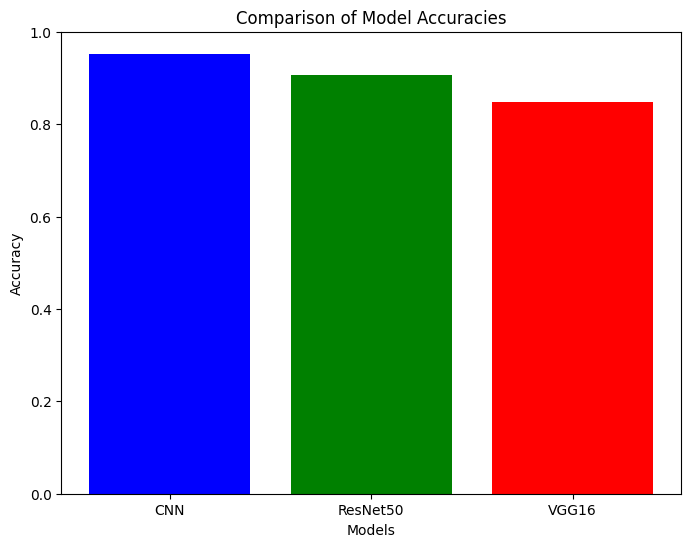

In [ ]:

accuracy_cnn = history_cnn.history['accuracy'][-1]
test_accuracy_resnet = history_resnet.history['accuracy'][-1]
test_accuracy_vgg16 = history_vgg16.history['accuracy'][-1]

# Plotting the accuracies of the three models
plt.figure(figsize=(8, 6))
models = ['CNN', 'ResNet50', 'VGG16']
accuracies = [accuracy_cnn, test_accuracy_resnet, test_accuracy_vgg16]

plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set the y-axis limit to be between 0 and 1
plt.show()


# **Testing Individual Image Prediction with ResNet50**

1/1 [==============================] - 1s 1s/step


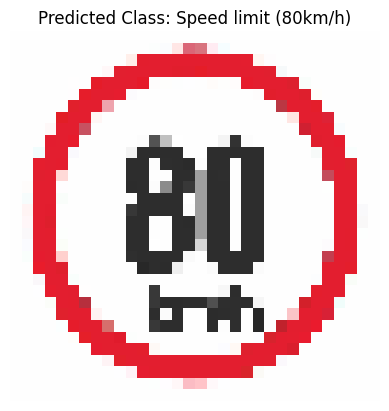

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import matplotlib.pyplot as plt

# Define the height and width expected by the ResNet50 model
image_height = 32
image_width = 32

# Load your ResNet50 model
resnet_model_path = "/content/resnet_model.pkl"
with open(resnet_model_path, 'rb') as f:
    resnet_model = pickle.load(f)

# Define the class names dictionary
class_names = {
    '0': 'Speed limit (20km/h)',
    '1': 'Speed limit (30km/h)',
    '2': 'Speed limit (50km/h)',
    '3': 'Speed limit (60km/h)',
    '4': 'Speed limit (70km/h)',
    '5': 'Speed limit (80km/h)',
    '6': 'End of speed limit (80km/h)',
    '7': 'Speed limit (100km/h)',
    '8': 'Speed limit (120km/h)',
    '9': 'No passing',
    '10': 'No passing veh over 3.5 tons',
    '11': 'Right-of-way at intersection',
    '12': 'Priority road',
    '13': 'Yield',
    '14': 'Stop',
    '15': 'No vehicles',
    '16': 'Veh > 3.5 tons prohibited',
    '17': 'No entry',
    '18': 'General caution',
    '19': 'Dangerous curve left',
    '20': 'Dangerous curve right',
    '21': 'Double curve',
    '22': 'Bumpy road',
    '23': 'Slippery road'
}

# Load the image
image_path = "/content/80.png"
img = keras_image.load_img(image_path, target_size=(image_height, image_width))

# Preprocess the image
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Preprocess for ResNet50

# Make prediction using the ResNet50 model
prediction = resnet_model.predict(img_array)

# Convert the prediction to a human-readable label
predicted_class_index = np.argmax(prediction)
predicted_class = class_names.get(str(predicted_class_index), "Unknown Class")

# Display the image with the predicted class
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class}')
plt.show()
